In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from time_series_service import series_to_supervised

In [36]:
# Read and prepare data to linear regression model

df = pd.read_csv('generated/btc_value_em_tweets_sentimental_score.csv')
df.columns = ['DateTime','Compound','Positive', 'Neutral', 'Negative', 'Price']
df = df[['DateTime','Negative','Neutral','Positive','Compound','Price']]
df = df[['DateTime', 'Compound','Price']]
df = df.sort_values('DateTime')
df.set_index('DateTime',inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 2020-07-01 to 2021-06-26
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Compound  361 non-null    float64
 1   Price     360 non-null    float64
dtypes: float64(2)
memory usage: 8.5+ KB


,Compound,Price
DateTime,,
2020-07-01,0.0,144.8
2020-07-02,0.0,18.0
2020-07-03,0.0,-67.3
2020-07-04,0.0,53.4
2020-07-05,0.0,-258.0


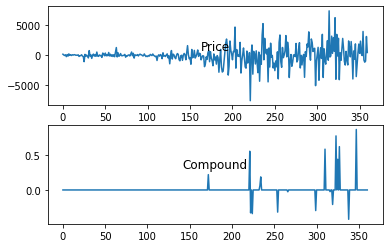

In [37]:
# Plot the time series of all features

columns_groups = [0,1]

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

i = 1
plt.figure()
for column_group in columns_groups:
    plt.subplot(len(columns_groups), 1, i)
    plt.plot(df.values[:, column_group])
    plt.title(df.columns[column_group], y=0.5, loc='center')
    i += 1
plt.show()

In [38]:
# Reframe the data so we can apply supervised learning techniques in a time series

n_days = 1
n_features = 1
n_obs = n_days * n_features

reframed = series_to_supervised(df.values, n_days, 1)
reframed = reframed.drop(reframed.columns[-1:], axis=1)

reframed.head()

,var1(t-1),var2(t-1),var1(t)
1,144.8,0.0,18.0
2,18.0,0.0,-67.3
3,-67.3,0.0,53.4
4,53.4,0.0,-258.0
5,-258.0,0.0,83.0


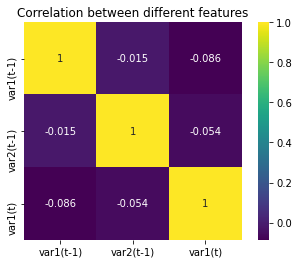

In [39]:
# Plot correlation matrix

correlation = reframed.corr()
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Correlation between different features')
plt.show();

In [54]:
# Create the varmax model, train it and plot the diagnostics

data = reframed.values

data_df = pd.DataFrame(data=data, columns=['var1(t-1)','var2(t-1)','var1(t)'])

non_zero_data = data_df[data_df['var2(t-1)']!=0]


scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(non_zero_data)

model = VAR(scaled)
model_fit = model.fit()
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 27, Jul, 2021
Time:                     17:04:39
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -6.26986
Nobs:                     16.0000    HQIC:                  -6.81963
Log likelihood:          -1.31467    FPE:                 0.00109520
AIC:                     -6.84930    Det(Omega_mle):     0.000560741
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.373988         0.328723            1.138           0.255
L1.y1         0.171197         0.299763            0.571           0.568
L1.y2         0.148111         0.237370            0.624           0.533
L1.y3         0.169836

In [58]:

predictions = model_fit.forecast(y=scaled, steps=len(scaled))
inv_predictions = scaler.inverse_transform(predictions)

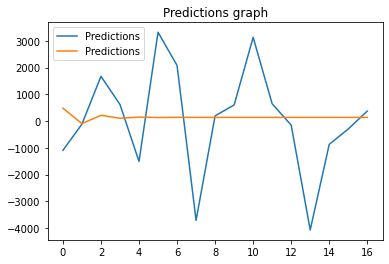

In [59]:
# Plot Results

plt.plot(non_zero_data['var1(t)'].values, label="Predictions")
plt.plot(inv_predictions[:, 2], label="Predictions")
plt.title("Predictions graph")
plt.legend(loc="upper left")

plt.show()

In [ ]:
# Print the results

mse = mean_squared_error(inv_y, inv_predictions)
r2 = r2_score(inv_y, inv_predictions)
rmse = np.sqrt(mse)

print("Coefficient of Determination  (R2):", r2)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Square Error: %.3f" % rmse)

In [ ]:
# Save the predictions data to csv file

df_sol = pd.DataFrame({'forecast':inv_predictions,'actual':inv_y})
df_sol.to_csv('generated/predictions_sv_lstm.csv')